In [ ]:
import os

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import glob
class ImageFolderWithPaths(datasets.ImageFolder):
 # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

PATH = "three_label_classifier.pt"


<class '__main__.ImageFolderWithPaths'>
18071
15364
validation set length:  18071
Dataloader size:  4518
Test Loader size:  3841


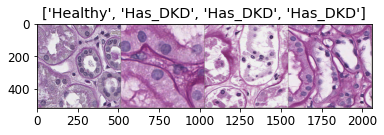

In [25]:
# Training 25672 Total - 13000 Healthy / 11000 Has_DKD / 1,700 CKD_noDM
# Validation 18071 Total - 15,988 Healthy / 1879 Has_DKD / 204 CKD_noDM
# Testing 14861 Total - 11,470 Healthy / 2318 Has_DKD / 1,073 CKD_noDM

# Try to find an equal number of patches from each set do better sampling

plt.ion()   # interactive mode
data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(512),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

temp_DKD = glob.glob('/data1/DKDimages/Three_Label_WSI/KPMP_WSI/Has_DKD/*')
wsi_HasDKD = []
wsi_all = []
for x in temp_DKD:
    
    dkd_split = x.split("/")[-1].split(".")[0].split('_')[0]
#     print(dkd_split)
    wsi_HasDKD.append(dkd_split)
    wsi_all.append(dkd_split)
# print("has DKD",wsi_HasDKD)
# print(len(wsi_HasDKD))
temp_Healthy = glob.glob('/data1/DKDimages/Three_Label_WSI/KPMP_WSI/Healthy/*')
wsi_Healthy = []
for x in temp_Healthy:
    
    dkd_split = x.split("/")[-1].split(".")[0].split('_')[0]
#     print(dkd_split)
    wsi_Healthy.append(dkd_split)
    wsi_all.append(dkd_split)
# print("Healthy",wsi_Healthy)
# print(len(wsi_Healthy))
# print(wsi_all)
# print("all len",len(wsi_all))

temp_CKD_noDM = glob.glob('/data1/DKDimages/Three_Label_WSI/KPMP_WSI/CKD_noDM/*')
wsi_CKD_noDM = []
for x in temp_CKD_noDM:
    
    dkd_split = x.split("/")[-1].split(".")[0].split('_')[0]
#     print(dkd_split)
    wsi_CKD_noDM.append(dkd_split)
    wsi_all.append(dkd_split)
# print("ckd",wsi_CKD_noDM)
# print(len(wsi_CKD_noDM))


# print(wsi_all)
# print("all len",len(wsi_all))
# wsi_dict = dict()
# for i in wsi_all:
#     wsi_dict[i] = dict()
#     wsi_dict[i]["Healthy"] = 0
#     wsi_dict[i]["Has_DKD"] = 0
#     wsi_dict[i]["CKD_noDM"] = 0
# print(wsi_dict)


params = {'batch_size': 4,
          'shuffle': True,
          'num_workers': 8}

class_names = ('CKD_noDM','Has_DKD', 'Healthy', )
# data_dir = '/projectnb/vkolagrp/Tsurendr/Deepslide-NewLabels/train_folder/'
# print(os.path.exists(data_dir))

# training_set = Dataset((os.path.join(data_dir, 'train')), labels)
# training_generator = torch.utils.data.DataLoader(training_set, **params)

# validation_set = Dataset(os.path.join(data_dir, 'val'), labels)
# validation_generator = torch.utils.data.DataLoader(validation_set, **params)



# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['train', 'val']}

image_datasets_train = ImageFolderWithPaths('/data1/DKDimages/Pyhist_Patches/train', transform = data_transforms)
# type(image_datasets_train)
# for i, data in enumerate(image_datasets_train):
#     print(data)
print(type(image_datasets_train))
# print(len(image_datasets_train))
image_datasets_val = ImageFolderWithPaths('/data1/DKDimages/Pyhist_Patches/val', transform = data_transforms)
print(len(image_datasets_val))
image_datasets_test = ImageFolderWithPaths('/data1/DKDimages/Pyhist_Patches/test', transform = data_transforms)
print(len(image_datasets_test))
# print(image_datasets_val)
print("validation set length: ", len(image_datasets_val))
dataloader_train = torch.utils.data.DataLoader(image_datasets_train, batch_size=4,
                                             shuffle=True, num_workers=8)
print(dataloader_train)
dataloader_val = torch.utils.data.DataLoader(image_datasets_val, batch_size=4,
                                             shuffle=True, num_workers=8)
dataloader_test = torch.utils.data.DataLoader(image_datasets_test, batch_size=4,
                                             shuffle=True, num_workers=8)
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
#                                              shuffle=True, num_workers=8)
#                for x in ['train', 'val']}
print("Dataloader size: ", len(dataloader_val))
print("Test Loader size: ", len(dataloader_test))
dataset_sizes_train = len(image_datasets_train)
dataset_sizes_val = len(image_datasets_val)
# class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path_sum = 0
# for i, data in enumerate(dataloader_val):
#     images,labels,paths = data
# #     print( paths[3])
#     if paths[0]: 
#         path_sum+=1
#         print("path 0", paths[0])
#     if paths[1]:
#         path_sum+=1
#         print("path 1", paths[1])
        
#     try:
#         if paths[2]:
#             path_sum+=1
#             print("path 2", paths[2])
            
#     except IndexError:
#         pass
    
#     try:
#         if paths[3]:
#             path_sum+=1
#             print("path 3", paths[3])
            
#     except IndexError:
#         pass
# print("done")
# print(path_sum)
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# # Get a batch of training data
inputs, classes, paths = next(iter(dataloader_train))
# print(classes)
# print(inputs)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])



In [ ]:

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
#     print("hello")
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            if phase == "train":
                
                for inputs, labels, paths in dataloader_train:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
#                     print(min(labels))
#                     print(max(labels))
#                     print(inputs.shape)
        
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
#                         print(torch.max(outputs, 1))
#                         print(torch.min(outputs, 1))
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
            
            
            if phase == "val":
                
                for inputs, labels, paths in dataloader_val:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            if phase == 'train':
                epoch_loss = running_loss / dataset_sizes_train
                epoch_acc = running_corrects.double() / dataset_sizes_train
            if phase == 'val':
                epoch_loss = running_loss / dataset_sizes_val
                epoch_acc = running_corrects.double() / dataset_sizes_val
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model, PATH)
    return model



#Whole Covnet        
# model_ft = models.resnet18(pretrained=True)
# num_ftrs = model_ft.fc.in_features
# # Here the size of each output sample is set to 2.
# # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model_ft.fc = nn.Linear(num_ftrs, 2)

# model_ft = model_ft.to(device)

# criterion = nn.CrossEntropyLoss()

# # Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=25)
# visualize_model(model_ft)

#final layer ########################

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_conv.outlayer = nn.Linear(512 * 1 * 1, 3)
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=20)



In [27]:
import seaborn as sns
def visualize_model(model,dataloader):
    wsi_dict = dict()
    for i in wsi_all:
        wsi_dict[i] = dict()
        wsi_dict[i]["Healthy"] = 0
        wsi_dict[i]["Has_DKD"] = 0
        wsi_dict[i]["CKD_noDM"] = 0
    # print(wsi_dict)
    # print(len(dataloader))
    was_training = model.training
    model.eval()
    # images_so_far = 0
    # fig = plt.figure()
    path_sum = 0
    len_class_names = len(class_names)
    confusion_matrix = torch.zeros(len_class_names, len_class_names)
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, labels, filenames = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # print(labels) 

            outputs = model(inputs)
            # print(torch.sigmoid(outputs)[0])
            _, preds = torch.max(outputs, 1)
            # print(preds[0])
#             print(filenames)
            try:
                if filenames[0]: 
                    path_sum+=1
#                     print("path 0", filenames[0])
#                     print("prediction: ", class_names[preds[0]])
                    temp = filenames[0].split("/")[-1].split(".")[0].split('_')[0]
    #                 dict_key = temp[0]+"_"+temp[1]+"_"+temp[2]+"_"+temp[3]
                    dict_key = temp
    #                 print(dict_key)
                    if dict_key in wsi_all:
                        if class_names[preds[0]] == "Has_DKD":
                            wsi_dict[dict_key]["Has_DKD"] += 1
                            # print(dict_key,wsi_dict[dict_key]["Has_DKD"])
                        elif class_names[preds[0]] == "Healthy":
                            wsi_dict[dict_key]["Healthy"] += 1
                            # print(dict_key,wsi_dict[dict_key]["Healthy"])
                        elif class_names[preds[0]] == "CKD_noDM":
                            wsi_dict[dict_key]["CKD_noDM"] += 1
                            # print( dict_key,wsi_dict[dict_key]["CKD_noDM"])
            except IndexError:
                pass
            try:
                
                if filenames[1]:
                    path_sum+=1
#                     print("path 1", filenames[1])
#                     print("prediction: ", class_names[preds[1]])
                    temp = filenames[1].split("/")[-1].split(".")[0].split('_')[0]
    #                 dict_key = temp[0]+"_"+temp[1]+"_"+temp[2]+"_"+temp[3]
                    dict_key = temp
    #                 print(dict_key)                
                    if dict_key in wsi_all:
                        if class_names[preds[1]] == "Has_DKD":
                            wsi_dict[dict_key]["Has_DKD"] += 1
                            # print(dict_key,wsi_dict[dict_key]["Has_DKD"])
                        elif class_names[preds[1]] == "Healthy":
                            wsi_dict[dict_key]["Healthy"] += 1
                            # print(dict_key,wsi_dict[dict_key]["Healthy"])
                        elif class_names[preds[1]] == "CKD_noDM":
                            wsi_dict[dict_key]["CKD_noDM"] += 1
                            # print( dict_key,wsi_dict[dict_key]["CKD_noDM"])
    #             print(filenames[2])
            except IndexError:
                pass
            try:
                if filenames[2]:
                    path_sum+=1
#                     print("path 2", filenames[2])
#                     print("prediction: ", class_names[preds[2]])
                    temp = filenames[2].split("/")[-1].split(".")[0].split('_')[0]
                    dict_key = temp
#                     dict_key = temp[0]+"_"+temp[1]+"_"+temp[2]+"_"+temp[3]
#                     print(dict_key)                    
                    if dict_key in wsi_all:
                        if class_names[preds[2]] == "Has_DKD":
                            wsi_dict[dict_key]["Has_DKD"] += 1
                            # print(dict_key,wsi_dict[dict_key]["Has_DKD"])
                        elif class_names[preds[2]] == "Healthy":
                            wsi_dict[dict_key]["Healthy"] += 1
                            # print(dict_key,wsi_dict[dict_key]["Healthy"])
                        elif class_names[preds[2]] == "CKD_noDM":
                            wsi_dict[dict_key]["CKD_noDM"] += 1
                            # print( dict_key,wsi_dict[dict_key]["CKD_noDM"])
            except IndexError:
                pass

            try:
                if filenames[3]:
                    path_sum+=1
#                     print("path 3", filenames[3])
#                     print("prediction: ", class_names[preds[3]])
                    temp = filenames[3].split("/")[-1].split(".")[0].split('_')[0]
                    dict_key = temp
#                     dict_key = temp[0]+"_"+temp[1]+"_"+temp[2]+"_"+temp[3]
#                     print(dict_key)
                    if dict_key in wsi_all:
                        if class_names[preds[3]] == "Has_DKD":
                            wsi_dict[dict_key]["Has_DKD"] += 1
                            # print(dict_key,wsi_dict[dict_key]["Has_DKD"])
                        elif class_names[preds[3]] == "Healthy":
                            wsi_dict[dict_key]["Healthy"] += 1
                            # print(dict_key,wsi_dict[dict_key]["Healthy"])
                        elif class_names[preds[3]] == "CKD_noDM":
                            wsi_dict[dict_key]["CKD_noDM"] += 1
                            # print( dict_key,wsi_dict[dict_key]["CKD_noDM"])
            except IndexError:
                pass
        
            for t, p in zip(labels.view(-1), preds.view(-1)):
                            confusion_matrix[t.long(), p.long()] += 1

#             print(filenames[0])
#             [print(class_names[x]) for x in preds]
        
#             for j in range(inputs.size()[0]):
#                 images_so_far += 1
#                 ax = plt.subplot(num_images//2, 2, images_so_far)
#                 ax.axis('off')
#                 ax.set_title('predicted: {}'.format(class_names[preds[j]]))
#                 imshow(inputs.cpu().data[j])

#                 if images_so_far == num_images:
#                     model.train(mode=was_training)
#                     return
#         print(confusion_matrix)
#         print(confusion_matrix.diag()/confusion_matrix.sum(1))

#         sns.heatmap(confusion_matrix, annot=True)
        print("path_sum: ",path_sum)

        ax= plt.subplot()
        sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
        
        # labels, title and ticks
        ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
        ax.set_title('Confusion Matrix'); 
        ax.xaxis.set_ticklabels(['CKD_noDM', 'Has_DKD','Healthy']); ax.yaxis.set_ticklabels(['CKD_noDM', 'Has_DKD','Healthy'])
        print('Predicted label accuracy',(confusion_matrix.diag()/confusion_matrix.sum(1)))
        model.train(mode=was_training)
        return wsi_dict

       

path_sum:  18071
Predicted label accuracy tensor([0.4902, 0.7467, 0.9894])
Validation Slide Status: 
WSI:  fea35cdd-95d1-4d61-ac8a-f3a6a4c4566a  healthy:  0 has DKD:  0 CKD_noDM 0 total patch num 0
WSI:  230ae9a5-1728-4bda-a885-c7e161666b25  healthy:  0 has DKD:  0 CKD_noDM 0 total patch num 0
WSI:  d6c378ab-255a-4f41-a0c0-33cd7d873f73  healthy:  0 has DKD:  0 CKD_noDM 0 total patch num 0
WSI:  e6c166fd-0b8b-4dbe-8fea-7fd3310d9243  healthy:  0 has DKD:  0 CKD_noDM 0 total patch num 0
WSI:  59eaa15d-a1d5-4990-93bc-7b53b590fab5  healthy:  0 has DKD:  0 CKD_noDM 0 total patch num 0
WSI:  f1f7bccc-feb9-42fe-a76c-8a488e6b1986  healthy:  0 has DKD:  0 CKD_noDM 0 total patch num 0
WSI:  060e75ad-0819-4007-b5bc-18a39dbcefdd  healthy:  0 has DKD:  0 CKD_noDM 0 total patch num 0
WSI:  7f3d65c3-b7df-4f26-b7da-074ae184868e  healthy:  0 has DKD:  0 CKD_noDM 0 total patch num 0
WSI:  4d67cb77-12cd-49d4-b3bd-6f465fa68437  healthy:  0 has DKD:  0 CKD_noDM 0 total patch num 0
WSI:  ed4e6ba3-a00c-4240-8

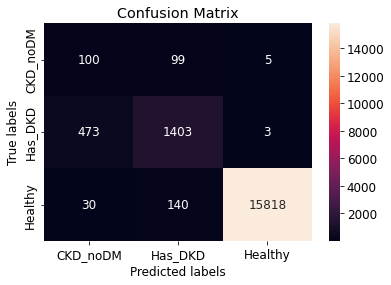

In [30]:
model = torch.load(PATH)
model.eval()
wsi_dict = visualize_model(model,dataloader_val)
print("Validation Slide Status: ")
# print(wsi_all)
for k in wsi_all:
#     print(k)
    print("WSI: ", k, " healthy: ", wsi_dict[k]['Healthy'], "has DKD: ", wsi_dict[k]['Has_DKD'],"CKD_noDM" ,wsi_dict[k]['CKD_noDM'], "total patch num", wsi_dict[k]['Healthy'] + wsi_dict[k]['CKD_noDM'] + wsi_dict[k]['Has_DKD'])
    if (max(wsi_dict[k]['Healthy'], wsi_dict[k]['Has_DKD'],wsi_dict[k]['CKD_noDM']) == wsi_dict[k]['Healthy']) and (wsi_dict[k]['Healthy'] != 0 or wsi_dict[k]['Has_DKD'] != 0 or wsi_dict[k]['CKD_noDM'] != 0 ):
        print("WSI: ", k, "Status: Healthy" )
    elif max(wsi_dict[k]['Healthy'], wsi_dict[k]['Has_DKD'],wsi_dict[k]['CKD_noDM']) == wsi_dict[k]['Has_DKD'] and (wsi_dict[k]['Healthy'] != 0 or wsi_dict[k]['Has_DKD'] != 0 or wsi_dict[k]['CKD_noDM'] != 0 ):
        print("WSI: ", k, "Status: Has_DKD" )
    elif max(wsi_dict[k]['Healthy'], wsi_dict[k]['Has_DKD'],wsi_dict[k]['CKD_noDM']) == wsi_dict[k]['CKD_noDM'] and (wsi_dict[k]['Healthy'] != 0 or wsi_dict[k]['Has_DKD'] != 0 or wsi_dict[k]['CKD_noDM'] != 0 ):
        print("WSI: ", k, "Status: CKD_noDM" )
plt.ioff()
plt.show() 

path_sum:  15364
Predicted label accuracy tensor([0.0158, 0.4470, 0.9805])
Testing status: 
WSI:  fea35cdd-95d1-4d61-ac8a-f3a6a4c4566a  healthy:  0 has DKD:  0 CKD_noDM 0 total patch num 0
WSI:  230ae9a5-1728-4bda-a885-c7e161666b25  healthy:  0 has DKD:  0 CKD_noDM 0 total patch num 0
WSI:  d6c378ab-255a-4f41-a0c0-33cd7d873f73  healthy:  0 has DKD:  0 CKD_noDM 0 total patch num 0
WSI:  e6c166fd-0b8b-4dbe-8fea-7fd3310d9243  healthy:  3 has DKD:  194 CKD_noDM 524 total patch num 721
WSI:  e6c166fd-0b8b-4dbe-8fea-7fd3310d9243 Status: CKD_noDM
WSI:  59eaa15d-a1d5-4990-93bc-7b53b590fab5  healthy:  0 has DKD:  77 CKD_noDM 68 total patch num 145
WSI:  59eaa15d-a1d5-4990-93bc-7b53b590fab5 Status: Has_DKD
WSI:  f1f7bccc-feb9-42fe-a76c-8a488e6b1986  healthy:  4 has DKD:  170 CKD_noDM 195 total patch num 369
WSI:  f1f7bccc-feb9-42fe-a76c-8a488e6b1986 Status: CKD_noDM
WSI:  060e75ad-0819-4007-b5bc-18a39dbcefdd  healthy:  11 has DKD:  282 CKD_noDM 210 total patch num 503
WSI:  060e75ad-0819-4007-b5

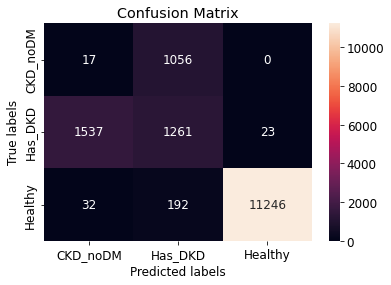

In [29]:
wsi_dict = visualize_model(model,dataloader_test)    
print("Testing status: ")
# print(wsi_all)
for k in wsi_all:
#     print(k)
    print("WSI: ", k, " healthy: ", wsi_dict[k]['Healthy'], "has DKD: ", wsi_dict[k]['Has_DKD'],"CKD_noDM" ,wsi_dict[k]['CKD_noDM'], "total patch num", wsi_dict[k]['Healthy'] + wsi_dict[k]['CKD_noDM'] + wsi_dict[k]['Has_DKD'])
    if (max(wsi_dict[k]['Healthy'], wsi_dict[k]['Has_DKD'],wsi_dict[k]['CKD_noDM']) == wsi_dict[k]['Healthy']) and (wsi_dict[k]['Healthy'] != 0 or wsi_dict[k]['Has_DKD'] != 0 or wsi_dict[k]['CKD_noDM'] != 0 ):
        print("WSI: ", k, "Status: Healthy" )
    elif max(wsi_dict[k]['Healthy'], wsi_dict[k]['Has_DKD'],wsi_dict[k]['CKD_noDM']) == wsi_dict[k]['Has_DKD'] and (wsi_dict[k]['Healthy'] != 0 or wsi_dict[k]['Has_DKD'] != 0 or wsi_dict[k]['CKD_noDM'] != 0 ):
        print("WSI: ", k, "Status: Has_DKD" )
    elif max(wsi_dict[k]['Healthy'], wsi_dict[k]['Has_DKD'],wsi_dict[k]['CKD_noDM']) == wsi_dict[k]['CKD_noDM'] and (wsi_dict[k]['Healthy'] != 0 or wsi_dict[k]['Has_DKD'] != 0 or wsi_dict[k]['CKD_noDM'] != 0 ):
        print("WSI: ", k, "Status: CKD_noDM" )

In [ ]:
import pandas as pd
from openslide import OpenSlide
df_labels = pd.read_csv("Test_labels.csv")
df_labels

In [ ]:
from torch.utils.data import Dataset
class MyDaatset(Dataset):
    def __init__(self, path, labels_wsi,transform):
        self.files = glob.glob(path)
        print(type(self.files))
        self.transform = transform
        self.labels = labels_wsi
    def __getitem__(self, item):
        file = self.files[item]
        name = file
        label = self.labels
        file = Image.open(file)
        file = self.transform(file)
        if label.startswith("H-CKD"):
            label=0
        elif label.startswith("Healthy"):
            label=2
        elif label.startswith("Has_DKD"):
            label=1
        return file,label,name
    def __len__(self):
        return len(self.files)


print("hei")


In [ ]:
#so i pass a wsi into the function
# inside the function i get the size of the wsi as well as the tsv and patches for it
# so the data loader essentially tests only the values of 1 image at a time.
from PIL import Image, ImageOps, ImageEnhance 
import openslide
import math
def slide_to_scaled_pil_image(slide, SCALE_FACTOR):

    large_w, large_h = slide.dimensions
    new_w = math.floor(large_w / SCALE_FACTOR)
    new_h = math.floor(large_h / SCALE_FACTOR)
    level = slide.get_best_level_for_downsample(SCALE_FACTOR)
    whole_slide_image = slide.read_region((0, 0), level, slide.level_dimensions[level])
    whole_slide_image = whole_slide_image.convert("RGB")
    img = whole_slide_image.resize((new_w, new_h), Image.BILINEAR)
    return img, large_w, large_h, new_w, new_h


In [ ]:



def heatmap_generation(model,wsi_name,label):
    SCALE_FACTOR=64
    wsi_path = '/data1/DKDimages/ALL_WSI/'+wsi_name+'.svs'
    print(wsi_path)
    print(os.path.exists(wsi_path))
    wsi_image = OpenSlide(wsi_path)
    # pilImage = Image.open(wsi_path)
    img = openslide.OpenSlide(wsi_path)
    ds_img, large_w, large_h, new_w, new_h = slide_to_scaled_pil_image(img, SCALE_FACTOR)
    ds_img.save("test.png")
    # image = openslide.open_slide(wsi_path)
    # new_IM = Image.convert(image)
    # print(image.dimensions)
    path_sum = 0
    
    print(wsi_image.dimensions)
    print(ds_img.size)
    target_size = ds_img.size
    heat_map = Image.new('RGB', target_size)
    tsv_loc = '/data1/DKDimages/Pyhist_WSI_Image_Coords/' + wsi_name+ '/tile_selection.tsv'
    print(os.path.exists(tsv_loc))
    patch_loc = '/data1/DKDimages/All_patch_Folders/' + wsi_name+'_tiles'
    print(patch_loc)
    print(os.path.exists(patch_loc))
    tsv_coords = pd.read_csv(tsv_loc,sep='\t')
    # print(tsv_coords)
    # print(glob.glob(patch_loc+'/*'))
    temp = MyDaatset('/data1/DKDimages/All_patch_Folders/502d2911-4815-44e0-b66f-b1910e8808e9_S-1910-000043_PAS_1of2_tiles/*',labels_wsi = label,transform=data_transforms)
    # print(len(temp))
    # image_datasets_test_new = tempFolder('/data1/DKDimages/All_patch_Folders/502d2911-4815-44e0-b66f-b1910e8808e9_S-1910-000043_PAS_1of2_tiles',labels = label,transform = data_transforms)
    dataloader_test_new = torch.utils.data.DataLoader(temp, batch_size=4,
                                             shuffle=False, num_workers=8)  
    model.eval()

    with torch.no_grad():
        for i, data in enumerate(dataloader_test_new):
            inputs, labels, filenames = data
            # print(inputs,labels,filenames)
            # print(type(labels))
            inputs = inputs.to(device)
            labels = labels.to(device)
              

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
        
            # print(preds)
            try:
                if filenames[0]: 
                    path_sum+=1
                    # print("path 0", filenames[0])
                    # print("prediction: ", class_names[preds[0]])
                    temp = filenames[0].split("/")[-1].split(".")[0]
    #                 dict_key = temp[0]+"_"+temp[1]+"_"+temp[2]+"_"+temp[3]
                    dict_key = temp
                    # print(dict_key)

                    if class_names[preds[0]] == "Has_DKD":
                        # heat = np.full(shape=(512, 512,3),fill_value=(0,0,255)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8)) 
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),(255,0,0))
                    elif class_names[preds[0]] == "Healthy":
                        # heat = np.full(shape=(512, 512,3),fill_value=(0,255,0)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8))
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),(0,255,0)) 
                    elif class_names[preds[0]] == "H-CKD":
                        # heat = np.full(shape=(512, 512,3),fill_value=(255,0,0)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8))
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),(0,0,255)) 
                    # heat = Image.new('RGB',(512,512),(255,0,0))
                    # heat.save("just_img.png")
                    if (tsv_coords[tsv_coords["Tile"] == (dict_key)]['Keep'].iloc[0] == 1):
                        
                        x = int((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Column'].iloc[0])*int(512)/SCALE_FACTOR)
                        y = int((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Row'].iloc[0])*int(512)/SCALE_FACTOR)
                        # print((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Keep'].iloc[0])) 
                        heat_map.paste(im=heat, box=(x,y))

                    # print(x,y)
            except IndexError:
                pass
            try:
                
                if filenames[1]:
                    path_sum+=1
                    # print("path 1", filenames[1])
                    # print("prediction: ", class_names[preds[1]])
                    temp = filenames[1].split("/")[-1].split(".")[0]
                    dict_key = temp
                    # print(dict_key)                

                    if class_names[preds[1]] == "Has_DKD":
                        #  heat = np.full(shape=(512, 512,3),fill_value=(0,0,255)).astype(np.uint32)
                        #  heat = Image.fromarray((heat * 255).astype(np.uint8))
                         heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),(255,0,0)) 
                    elif class_names[preds[1]] == "Healthy":
                        #  heat = np.full(shape=(512, 512,3),fill_value=(0,255,0)).astype(np.uint32)
                        #  heat = Image.fromarray((heat * 255).astype(np.uint8))
                         heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),(0,255,0)) 
                    elif class_names[preds[1]] == "H-CKD":
                        #  heat = np.full(shape=(512, 512,3),fill_value=(255,0,0)).astype(np.uint32)
                        #  heat = Image.fromarray((heat * 255).astype(np.uint8))
                         heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),(0,0,255)) 
                    
                    if (tsv_coords[tsv_coords["Tile"] == (dict_key)]['Keep'].iloc[0] == 1):
                        
                        x = int((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Column'].iloc[0])*int(512)/SCALE_FACTOR)
                        y = int((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Row'].iloc[0])*int(512)/SCALE_FACTOR)
                        # print((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Keep'].iloc[0])) 
                        heat_map.paste(im=heat, box=(x,y))
                    
    #             print(filenames[2])
            except IndexError:
                pass
            try:
                if filenames[2]:
                    path_sum+=1
                    # print("path 2", filenames[2])
                    # print("prediction: ", class_names[preds[2]])
                    temp = filenames[2].split("/")[-1].split(".")[0]
                    dict_key = temp
#                     dict_key = temp[0]+"_"+temp[1]+"_"+temp[2]+"_"+temp[3]
                    # print(dict_key)                    

                    if class_names[preds[2]] == "Has_DKD":
                        # heat = np.full(shape=(512, 512,3),fill_value=(0,0,255)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8))
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),(255,0,0)) 
                    elif class_names[preds[2]] == "Healthy":
                        # heat = np.full(shape=(512, 512,3),fill_value=(0,255,0)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8))
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),(0,255,0)) 
                    elif class_names[preds[2]] == "H-CKD":
                        # heat = np.full(shape=(512, 512,3),fill_value=(255,0,0)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8))
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),(0,0,255)) 
                    
                    if (tsv_coords[tsv_coords["Tile"] == (dict_key)]['Keep'].iloc[0] == 1):
                        
                        x = int((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Column'].iloc[0])*int(512)/SCALE_FACTOR)
                        y = int((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Row'].iloc[0])*int(512)/SCALE_FACTOR)
                        print((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Keep'].iloc[0])) 
                        heat_map.paste(im=heat, box=(x,y))  
            except IndexError:
                pass

            try:
                if filenames[3]:
                    path_sum+=1
                    # print("path 3", filenames[3])
                    # print("prediction: ", class_names[preds[3]])
                    temp = filenames[3].split("/")[-1].split(".")[0]
                    dict_key = temp
#                     dict_key = temp[0]+"_"+temp[1]+"_"+temp[2]+"_"+temp[3]
                    # print(dict_key)

                    if class_names[preds[3]] == "Has_DKD":
                        # heat = np.full(shape=(512, 512, 3),fill_value=(0,0,255)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8))
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),(255,0,0))
                    elif class_names[preds[3]] == "Healthy":
                        # heat = np.full(shape=(512, 512, 3),fill_value=(0,255,0)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8))
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),(0,255,0))
                    elif class_names[preds[3]] == "H-CKD":
                        # heat = np.full(shape=(512, 512, 3),fill_value=(255,0,0)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8))
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),(0,0,255))
                    
                    if (tsv_coords[tsv_coords["Tile"] == (dict_key)]['Keep'].iloc[0] == 1):
                        
                        x = int((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Column'].iloc[0])*int(512)/SCALE_FACTOR)
                        y = int((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Row'].iloc[0])*int(512)/SCALE_FACTOR)
                        print((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Keep'].iloc[0])) 
                        heat_map.paste(im=heat, box=(x,y))
                    
            except IndexError:
                pass
        heat_map.save('mask.png')
        downsampled_img = Image.blend(ds_img, heat_map, 0.4)
        downsampled_img.save("heatmap.png")
        print(path_sum)
        
        
test_list = df_labels["filenames"].tolist()
print(test_list[0])
wsi_label = df_labels[df_labels["filenames"] == (test_list[0])]['labels'].iloc[0]
print(wsi_label)
model = torch.load(PATH)
model.eval()
heatmap_generation(model,test_list[0],wsi_label) 

502d2911-4815-44e0-b66f-b1910e8808e9_S-1910-000043_PAS_1of2
H-CKD
/data1/DKDimages/ALL_WSI/502d2911-4815-44e0-b66f-b1910e8808e9_S-1910-000043_PAS_1of2.svs
True
(139509, 53875)
(4359, 1683)
True
/data1/DKDimages/All_patch_Folders/502d2911-4815-44e0-b66f-b1910e8808e9_S-1910-000043_PAS_1of2_tiles
True
<class 'list'>
(41, 255, 205, 255)
path 0 /data1/DKDimages/All_patch_Folders/502d2911-4815-44e0-b66f-b1910e8808e9_S-1910-000043_PAS_1of2_tiles/502d2911-4815-44e0-b66f-b1910e8808e9_S-1910-000043_PAS_1of2_21795.png
prediction probability:  tensor([[0.4289, 0.9842, 0.0083],
        [0.8177, 0.9935, 0.0029],
        [0.5191, 0.9980, 0.0014],
        [0.0237, 0.9985, 0.0305]], device='cuda:0')
tensor(0.4289)
prediction:  Has_DKD
path 1 /data1/DKDimages/All_patch_Folders/502d2911-4815-44e0-b66f-b1910e8808e9_S-1910-000043_PAS_1of2_tiles/502d2911-4815-44e0-b66f-b1910e8808e9_S-1910-000043_PAS_1of2_20165.png
prediction probability:  tensor([[0.4289, 0.9842, 0.0083],
        [0.8177, 0.9935, 0.0029],
 

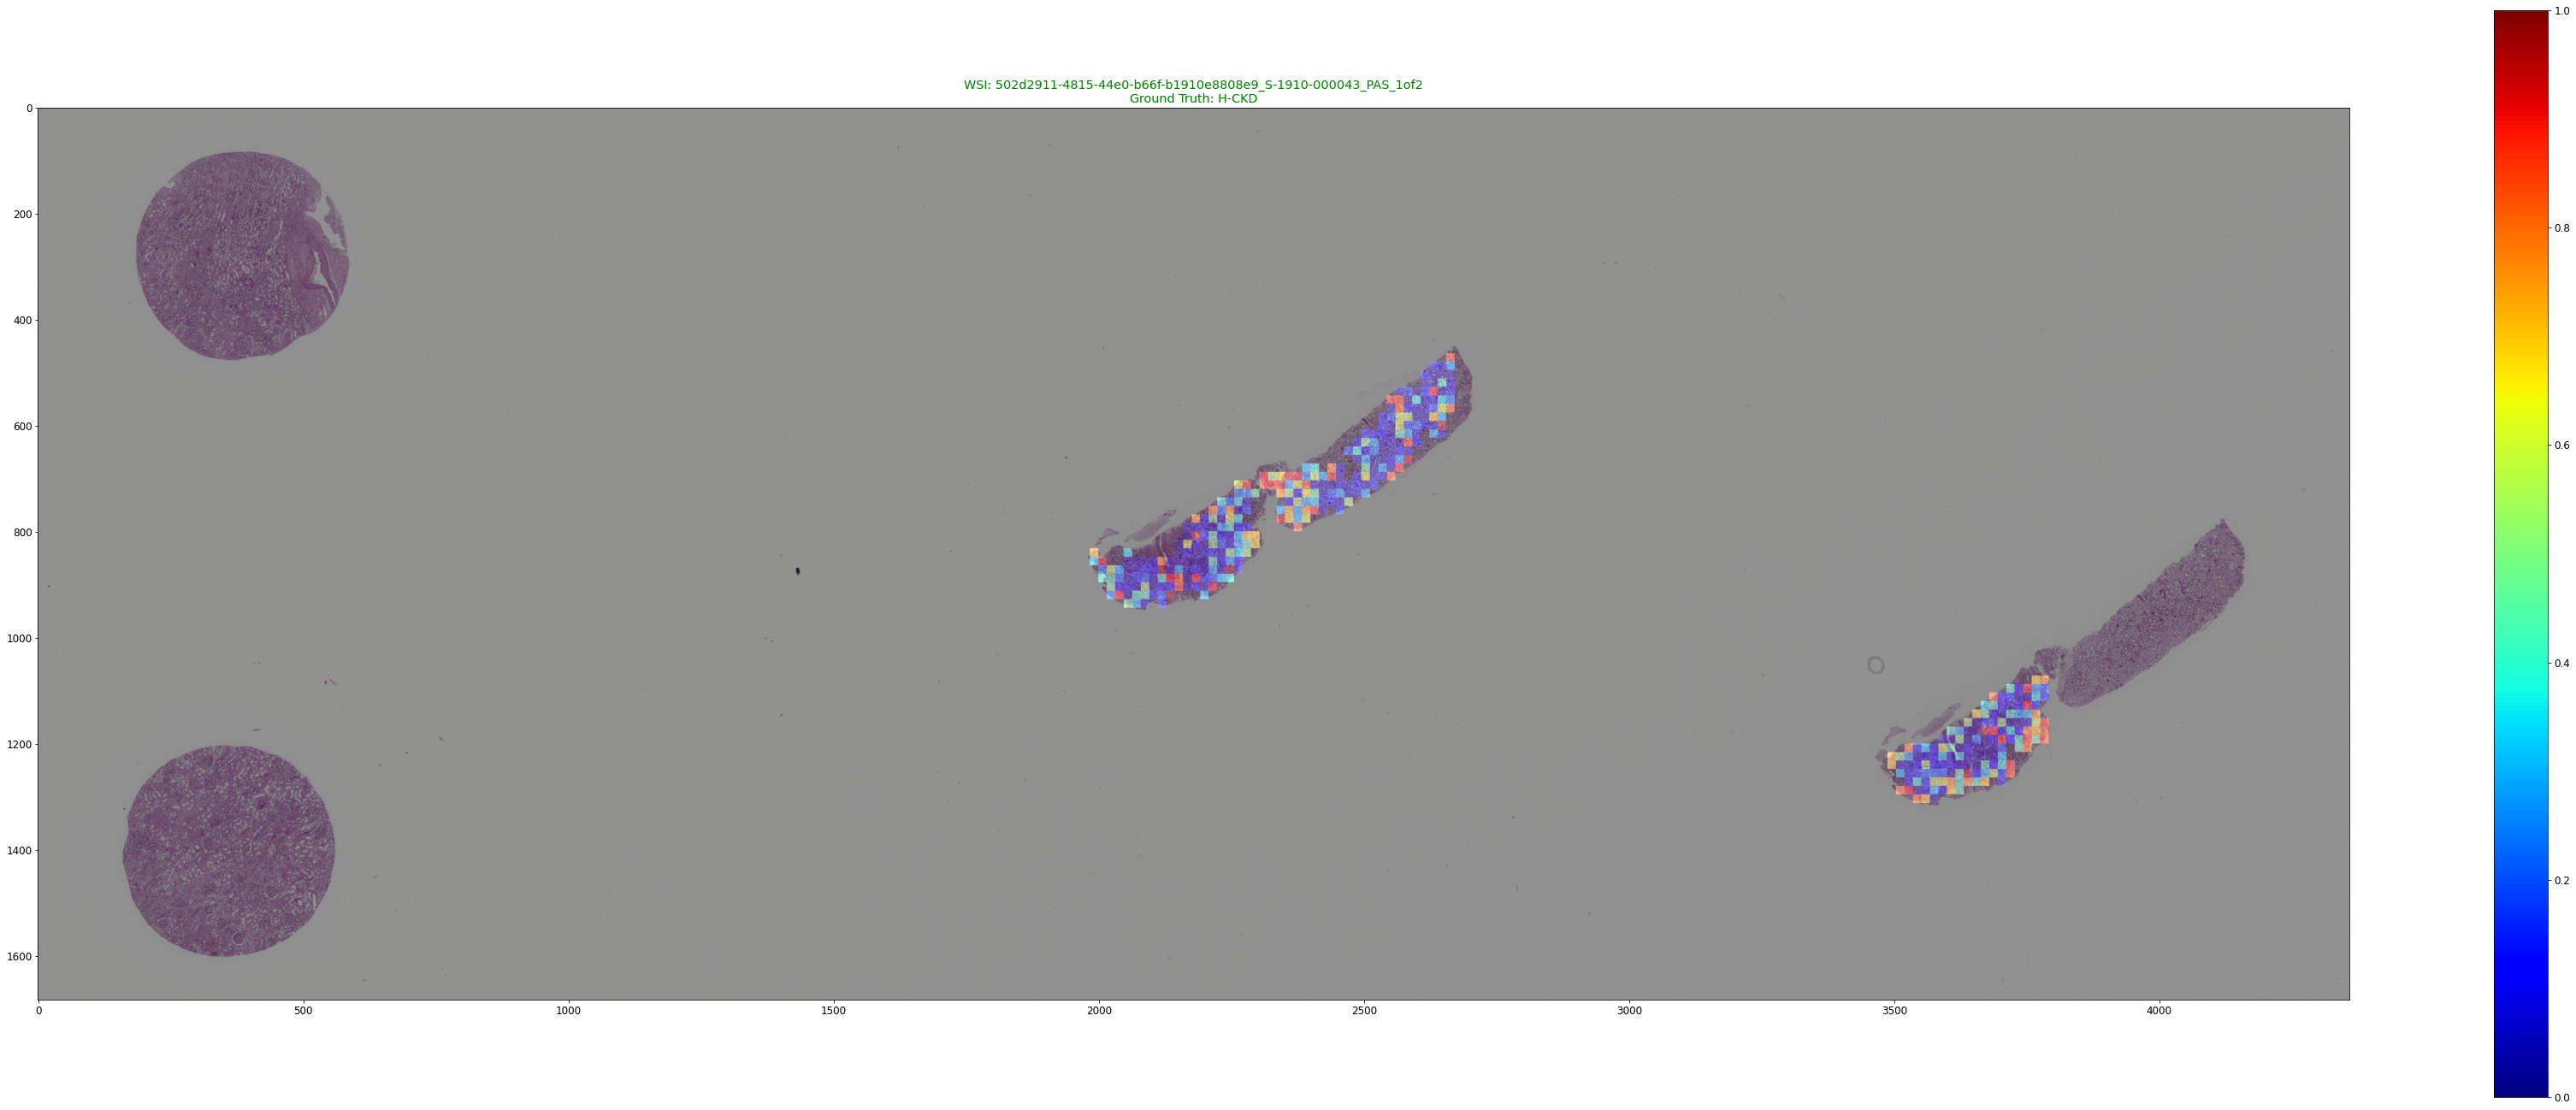

In [24]:
import matplotlib
import matplotlib.pyplot as plt
def heatmap_probability_generation(model,wsi_name,label):
    SCALE_FACTOR=32
    wsi_path = '/data1/DKDimages/ALL_WSI/'+wsi_name+'.svs'
    print(wsi_path)
    print(os.path.exists(wsi_path))
    wsi_image = OpenSlide(wsi_path)
    # pilImage = Image.open(wsi_path)
    img = openslide.OpenSlide(wsi_path)
    ds_img, large_w, large_h, new_w, new_h = slide_to_scaled_pil_image(img, SCALE_FACTOR)
    ds_img.save("test.png")
    # image = openslide.open_slide(wsi_path)
    # new_IM = Image.convert(image)
    # print(image.dimensions)
    path_sum = 0
    
    print(wsi_image.dimensions)
    print(ds_img.size)
    target_size = ds_img.size
    heat_map = Image.new('RGB', target_size)
    tsv_loc = '/data1/DKDimages/Pyhist_WSI_Image_Coords/' + wsi_name+ '/tile_selection.tsv'
    print(os.path.exists(tsv_loc))
    patch_loc = '/data1/DKDimages/All_patch_Folders/' + wsi_name+'_tiles'
    print(patch_loc)
    print(os.path.exists(patch_loc))
    tsv_coords = pd.read_csv(tsv_loc,sep='\t')
    # print(tsv_coords)
    # print(glob.glob(patch_loc+'/*'))
    temp = MyDaatset('/data1/DKDimages/All_patch_Folders/502d2911-4815-44e0-b66f-b1910e8808e9_S-1910-000043_PAS_1of2_tiles/*',labels_wsi = label,transform=data_transforms)
    # print(len(temp))
    # image_datasets_test_new = tempFolder('/data1/DKDimages/All_patch_Folders/502d2911-4815-44e0-b66f-b1910e8808e9_S-1910-000043_PAS_1of2_tiles',labels = label,transform = data_transforms)
    dataloader_test_new = torch.utils.data.DataLoader(temp, batch_size=4,
                                             shuffle=False, num_workers=8)  
    model.eval()
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
    cmap = matplotlib.cm.get_cmap('jet')
    
    plt_colors = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
    print(matplotlib.cm.jet(norm(0.4), bytes = True))
     
    # img_color.save("img_color.png")
    # matplotlib.view_colormap(plt_colors)
    with torch.no_grad():
        for i, data in enumerate(dataloader_test_new):
            inputs, labels, filenames = data
            # print(inputs,labels,filenames)
            # print(type(labels))
            inputs = inputs.to(device)
            labels = labels.to(device)
              

            outputs = model(inputs)
            
            _, preds = torch.max(outputs, 1)
            probabilites = torch.sigmoid(outputs)
            # print(preds)
            try:
                if filenames[0]:
                    if label == 'Has_DKD':
                        compare = probabilites[0][1]
                    elif label == 'Healthy':
                        compare = probabilites[0][2]
                    elif label == 'H-CKD':
                        compare = probabilites[0][0]
                    path_sum+=1
                    compare = compare.cpu()
                    color_val = matplotlib.cm.jet(norm(compare), bytes = True)
                    
                    print("path 0", filenames[0])
                    print("prediction probability: ", torch.sigmoid(outputs))
                    print(compare) 
                    print("prediction: ", class_names[preds[0]])
                    temp = filenames[0].split("/")[-1].split(".")[0]
    #                 dict_key = temp[0]+"_"+temp[1]+"_"+temp[2]+"_"+temp[3]
                    dict_key = temp
                    # print(dict_key)

                    if class_names[preds[0]] == "Has_DKD":
                        # heat = np.full(shape=(512, 512,3),fill_value=(0,0,255)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8)) 
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),color_val)
                    elif class_names[preds[0]] == "Healthy":
                        # heat = np.full(shape=(512, 512,3),fill_value=(0,255,0)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8))
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),color_val) 
                    elif class_names[preds[0]] == "H-CKD":
                        # heat = np.full(shape=(512, 512,3),fill_value=(255,0,0)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8))
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),color_val) 
                    # heat = Image.new('RGB',(512,512),(255,0,0))
                    # heat.save("just_img.png")
                    if (tsv_coords[tsv_coords["Tile"] == (dict_key)]['Keep'].iloc[0] == 1):
                        
                        x = int((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Column'].iloc[0])*int(512)/SCALE_FACTOR)
                        y = int((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Row'].iloc[0])*int(512)/SCALE_FACTOR)
                        # print((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Keep'].iloc[0])) 
                        heat_map.paste(im=heat, box=(x,y))

                    # print(x,y)
            except IndexError:
                pass
            try:
                
                if filenames[1]:
                    if label == 'Has_DKD':
                        compare = probabilites[1][1]
                    elif label == 'Healthy':
                        compare = probabilites[1][2]
                    elif label == 'H-CKD':
                        compare = probabilites[1][0]
                    path_sum+=1
                    print("path 1", filenames[1])
                    print("prediction probability: ", torch.sigmoid(outputs)) 
                    print(compare) 
                    print("prediction: ", class_names[preds[1]])
                    temp = filenames[1].split("/")[-1].split(".")[0]
                    dict_key = temp
                    # print(dict_key)                
                    compare = compare.cpu()
                    color_val = matplotlib.cm.jet(norm(compare), bytes = True)
                    if class_names[preds[1]] == "Has_DKD":
                        #  heat = np.full(shape=(512, 512,3),fill_value=(0,0,255)).astype(np.uint32)
                        #  heat = Image.fromarray((heat * 255).astype(np.uint8))
                         heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),color_val) 
                    elif class_names[preds[1]] == "Healthy":
                        #  heat = np.full(shape=(512, 512,3),fill_value=(0,255,0)).astype(np.uint32)
                        #  heat = Image.fromarray((heat * 255).astype(np.uint8))
                         heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),color_val) 
                    elif class_names[preds[1]] == "H-CKD":
                        #  heat = np.full(shape=(512, 512,3),fill_value=(255,0,0)).astype(np.uint32)
                        #  heat = Image.fromarray((heat * 255).astype(np.uint8))
                         heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),color_val) 
                    
                    if (tsv_coords[tsv_coords["Tile"] == (dict_key)]['Keep'].iloc[0] == 1):
                        
                        x = int((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Column'].iloc[0])*int(512)/SCALE_FACTOR)
                        y = int((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Row'].iloc[0])*int(512)/SCALE_FACTOR)
                        # print((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Keep'].iloc[0])) 
                        heat_map.paste(im=heat, box=(x,y))
                    
    #             print(filenames[2])
            except IndexError:
                pass
            try:
                if filenames[2]:
                    if label == 'Has_DKD':
                        compare = probabilites[2][1]
                    elif label == 'Healthy':
                        compare = probabilites[2][2]
                    elif label == 'H-CKD':
                        compare = probabilites[2][0]
                    path_sum+=1
                    
                    print("path 2", filenames[2])
                    print("prediction probability: ", torch.sigmoid(outputs)) 
                    print(compare) 
                    print("prediction: ", class_names[preds[2]])
                    temp = filenames[2].split("/")[-1].split(".")[0]
                    dict_key = temp
#                     dict_key = temp[0]+"_"+temp[1]+"_"+temp[2]+"_"+temp[3]
                    # print(dict_key)                    
                    compare = compare.cpu()
                    color_val = matplotlib.cm.jet(norm(compare), bytes = True)
                    if class_names[preds[2]] == "Has_DKD":
                        # heat = np.full(shape=(512, 512,3),fill_value=(0,0,255)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8))
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),color_val) 
                    elif class_names[preds[2]] == "Healthy":
                        # heat = np.full(shape=(512, 512,3),fill_value=(0,255,0)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8))
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),color_val) 
                    elif class_names[preds[2]] == "H-CKD":
                        # heat = np.full(shape=(512, 512,3),fill_value=(255,0,0)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8))
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),color_val) 
                    
                    if (tsv_coords[tsv_coords["Tile"] == (dict_key)]['Keep'].iloc[0] == 1):
                        
                        x = int((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Column'].iloc[0])*int(512)/SCALE_FACTOR)
                        y = int((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Row'].iloc[0])*int(512)/SCALE_FACTOR)
                        print((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Keep'].iloc[0])) 
                        heat_map.paste(im=heat, box=(x,y))  
            except IndexError:
                pass

            try:
                if filenames[3]:
                    if label == 'Has_DKD':
                        compare = probabilites[3][1]
                    elif label == 'Healthy':
                        compare = probabilites[3][2]
                    elif label == 'H-CKD':
                        compare = probabilites[3][0]
                    path_sum+=1
                    print("path 3", filenames[3])
                    print("prediction probability: ", torch.sigmoid(outputs)) 
                    print(compare) 
                    print("prediction: ", class_names[preds[3]])
                    temp = filenames[3].split("/")[-1].split(".")[0]
                    dict_key = temp
#                     dict_key = temp[0]+"_"+temp[1]+"_"+temp[2]+"_"+temp[3]
                    # print(dict_key)
                    compare = compare.cpu()
                    color_val = matplotlib.cm.jet(norm(compare), bytes = True)
                    if class_names[preds[3]] == "Has_DKD":
                        # heat = np.full(shape=(512, 512, 3),fill_value=(0,0,255)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8))
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),color_val)
                    elif class_names[preds[3]] == "Healthy":
                        # heat = np.full(shape=(512, 512, 3),fill_value=(0,255,0)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8))
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),color_val)
                    elif class_names[preds[3]] == "H-CKD":
                        # heat = np.full(shape=(512, 512, 3),fill_value=(255,0,0)).astype(np.uint32)
                        # heat = Image.fromarray((heat * 255).astype(np.uint8))
                        heat = Image.new('RGB',(int(512/SCALE_FACTOR),int(512/SCALE_FACTOR)),color_val)
                    
                    if (tsv_coords[tsv_coords["Tile"] == (dict_key)]['Keep'].iloc[0] == 1):
                        
                        x = int((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Column'].iloc[0])*int(512)/SCALE_FACTOR)
                        y = int((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Row'].iloc[0])*int(512)/SCALE_FACTOR)
                        print((tsv_coords[tsv_coords["Tile"] == (dict_key)]['Keep'].iloc[0])) 
                        heat_map.paste(im=heat, box=(x,y))
                    
            except IndexError:
                pass
        heat_map.save('mask.png')
        px = 1/plt.rcParams['figure.dpi']  # pixel in inches
        plt.subplots(figsize=(4359*px, 1683*px))
        downsampled_img = Image.blend(ds_img, heat_map, 0.4)
        plt.rc('figure', titlesize = 1200)
        plt.title("WSI: " + wsi_name +'\n' + "Ground Truth: " + label, color = 'green')
        plt.imshow(downsampled_img)
        plt.colorbar(plt_colors)
        
        plt.savefig('heatmap_colorbar.png')
        downsampled_img.save("heatmap_probability.png")
        print(path_sum)
        
        
test_list = df_labels["filenames"].tolist()
print(test_list[0])
wsi_label = df_labels[df_labels["filenames"] == (test_list[0])]['labels'].iloc[0]
print(wsi_label)
model = torch.load(PATH)
model.eval()
heatmap_probability_generation(model,test_list[0],wsi_label) 